In [2]:
# !pip install dowhy

import dowhy
import pandas as pd 
from dowhy import CausalModel
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Right heart catheterization causality analysis
* load data 
* counfounding exploration 
* identify target estimate
* estimamte the causal effect 
    * matching without propensity score (greedy/optimal)
    * propensity score and matching 
    * IPTW
    * sensitivity analysis
* Refute the estimate

* Reference: https://arshren.medium.com/exploring-causality-with-dowhy-8257732998e4

## Load Data

In [3]:
df = pd.read_csv('../data/rhc.csv')

selected_vars = ['swang1','death','adld3p','ca','sex','age']

subset = df[selected_vars]
print(subset.info())

subset['treatment'] = np.where(subset['swang1']=='RHC',True,False)
subset['death'] = np.where(subset['death']=='Yes',1,0)
subset['cancer'] = np.where(subset['ca']=='Yes',1,0)
subset['female'] = np.where(subset['sex']=='Female',1,0)
subset.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5735 entries, 0 to 5734
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   swang1  5735 non-null   object 
 1   death   5735 non-null   object 
 2   adld3p  1439 non-null   float64
 3   ca      5735 non-null   object 
 4   sex     5735 non-null   object 
 5   age     5735 non-null   float64
dtypes: float64(2), object(4)
memory usage: 269.0+ KB
None


,swang1,death,adld3p,ca,sex,age,treatment,cancer,female
0,No RHC,0,0.0,Yes,Male,70.25098,False,1,0
1,RHC,1,NaN,No,Female,78.17896,True,0,1
2,RHC,0,NaN,Yes,Female,46.09198,True,1,1


## counfounding exploration

In [22]:
causal_graph = """
        digraph {
        treatment;
        death;
        adld3p;
        cancer;
        age;
        U[label="Unobserved Confounders"];
        cancer -> treatment; age -> treatment;
        U->treatment; /*U->death; U->cancer;*/
        age -> death; cancer -> death; adld3p -> death; treatment -> death;
        }
"""


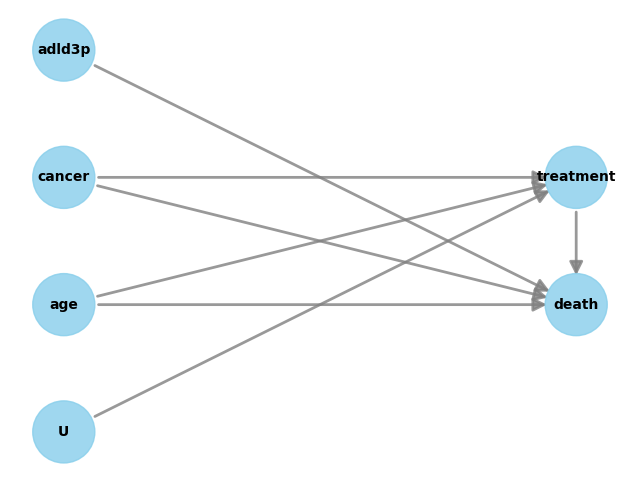

In [23]:
model= CausalModel(
        data = subset,
        graph=causal_graph.replace("\n", " "),
        treatment='treatment',
        outcome='death')
model.view_model()

##  Identify the Target Estimate

In [26]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                           
────────────(E[death|cancer,age])
d[treatment]                     
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→death then P(death|treatment,cancer,age,U) = P(death|treatment,cancer,age)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                               -1⎤
 ⎢ d          ⎛ d               ⎞  ⎥
E⎢────(death)⋅⎜────([treatment])⎟  ⎥
 ⎣d[U]        ⎝d[U]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→death then ¬(U →→{U})
Estimand assumption 2, Exclusion: If we remove {U}→{treatment}, then ¬({U}→death)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Estimate the Causal Effect

* method_name
    * Propensity Score Matching: “backdoor.propensity_score_matching”
    * Propensity Score Stratification: “backdoor.propensity_score_stratification”
    * Propensity Score-based Inverse Weighting: “backdoor.propensity_score_weighting”
    * Linear Regression: “backdoor.linear_regression”
    * Instrumental Variables: “iv.instrumental_variable”
    * Regression Discontinuity: “iv.regression_discontinuity”


In [39]:
causal_estimate_ipw = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate", # 'att'
                                            method_params={"weighting_scheme":"ips_weight"})
print(causal_estimate_ipw)
print("Causal Estimate is " + str(causal_estimate_ipw.value))
# Textual Interpreter
interpretation = causal_estimate_ipw.interpret(method_name="textual_effect_interpreter")

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                           
────────────(E[death|cancer,age])
d[treatment]                     
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→death then P(death|treatment,cancer,age,U) = P(death|treatment,cancer,age)

## Realized estimand
b: death~treatment+cancer+age
Target units: ate

## Estimate
Mean value: 0.05996252572412686

Causal Estimate is 0.05996252572412686
Increasing the treatment variable(s) [treatment] from 0 to 1 causes an increase of 0.05996252572412686 in the expected value of the outcome [['death']], over the data distribution/population represented by the dataset.


In [36]:
causal_estimate_psm = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_matching",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_weight"})
print(causal_estimate_psm)
print("Causal Estimate is " + str(causal_estimate_psm.value))
# Textual Interpreter
interpretation = causal_estimate_psm.interpret(method_name="textual_effect_interpreter")

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                           
────────────(E[death|cancer,age])
d[treatment]                     
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→death then P(death|treatment,cancer,age,U) = P(death|treatment,cancer,age)

## Realized estimand
b: death~treatment+cancer+age
Target units: ate

## Estimate
Mean value: 0.06329555361813426

Causal Estimate is 0.06329555361813426
Increasing the treatment variable(s) [treatment] from 0 to 1 causes an increase of 0.06329555361813426 in the expected value of the outcome [['death']], over the data distribution/population represented by the dataset.


## Refute the obtained estimate
* Random Common Cause — add an independent random variable as a common cause to the dataset; If the assumption was correct, the estimation should not change.
* Data Subset Refuter — replace the given dataset with a randomly selected subset; If the assumption was correct, the estimation should not change that much.
* Placebo Treatment — replace the true treatment variable with an independent random variable; If the assumption was correct, the estimate should go close to zero.

In [43]:
refute_results = model.refute_estimate(identified_estimand, causal_estimate_ipw,
                                       method_name="random_common_cause")
print(refute_results)

Refute: Add a random common cause
Estimated effect:0.05996252572412686
New effect:0.059962525724126865
p value:1.0



In [45]:
refutel = model.refute_estimate(identified_estimand, causal_estimate_ipw, "data_subset_refuter")
print(refutel)

Refute: Use a subset of data
Estimated effect:0.05996252572412686
New effect:0.060547319793954155
p value:0.8



In [42]:
refutation = model.refute_estimate(identified_estimand, causal_estimate_ipw, method_name='placebo_treatment_refuter',
                     placebo_type='permute', num_simulations=20)
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:0.05996252572412686
New effect:0.0109116261731305
p value:0.140046799416857

